Authenticate to GEE and GCP, install packages

In [1]:
#debug is True means you use only subset of data to test design/structure neural network
debug = False
learning_rate = 0.0001

In [2]:
!pip install --upgrade google-api-python-client   #install Python API
!python -c "from oauth2client import crypt"
!pip install gcsfs

Requirement already up-to-date: google-api-python-client in /opt/conda/lib/python3.7/site-packages (1.12.5)


In [3]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import ee
import pandas as pd
import IPython.display as display
from natsort import natsorted 

Load big TFRecord files (already pre-processed) use all files or a subset when testing model

In [6]:
files_low = !gsutil ls -r 'gs://era-ml-upressing/tfrecord_files_L3'
files_high = !gsutil ls -r 'gs://era-ml-upressing/tfrecord_files_H3'

# skip .. and .
fileslow = natsorted(files_low[2:])
fileshigh= natsorted(files_high[2:])

# use all available data:
files_train_low_slice = np.s_[:15]
files_test_low_slice = np.s_[15:]
files_train_high_slice = np.s_[:240]
files_test_high_slice = np.s_[240:]

# use a small subsample
if debug:
    files_train_low_slice = np.s_[:4]
    files_test_low_slice = np.s_[4:5]
    files_train_high_slice = np.s_[:64]
    files_test_high_slice = np.s_[64:80]
     
#use small part of all data
files_train_low = tf.data.TFRecordDataset(fileslow[files_train_low_slice], compression_type='GZIP')
files_test_low = tf.data.TFRecordDataset(fileslow[files_test_low_slice], compression_type='GZIP')
files_train_high = tf.data.TFRecordDataset(fileshigh[files_train_high_slice], compression_type='GZIP')
files_test_high = tf.data.TFRecordDataset(fileshigh[files_test_high_slice], compression_type='GZIP')

In [7]:
def parseTensor(x):
  return tf.io.parse_tensor(x, out_type=tf.float32)

train_low = files_train_low.map(parseTensor)
train_high = files_train_high.map(parseTensor)
train = tf.data.Dataset.zip((train_low.batch(32), train_high.batch(32)))
test_low = files_test_low.map(parseTensor)
test_high = files_test_high.map(parseTensor)
test = tf.data.Dataset.zip((test_low.batch(32), test_high.batch(32)))

In [ ]:
len(list(train_high))

#Define structure neural network

In [4]:
#Encoder
n = 64
chan = 1
input_img = tf.keras.layers.Input(shape=(n, n, chan))

# x = tf.keras.layers.BatchNormalization()(input_img)

l1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(input_img)
l2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l1)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(l2)

l4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l3)
l5 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(l5)

l7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l6)


In [5]:
#Decoder
l8 = tf.keras.layers.UpSampling2D(interpolation='nearest', size=(2, 2))(l7)
l9 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l8)
l10 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l9)
#l11 = tf.keras.layers.add([l10, l5])
#l11 = l10
l12 = tf.keras.layers.UpSampling2D(interpolation='nearest', size=(2, 2))(l10)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l13)
#l15 = tf.keras.layers.add([l14, l2])
#l15 = l14
l16 = tf.keras.layers.UpSampling2D(interpolation='nearest', size=(2, 2))(l14)
l17 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l16)
l18 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l17)

l19 = tf.keras.layers.UpSampling2D(interpolation='nearest', size=(2, 2))(l18)
l20 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l19)
l21 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l20)
decoded_image = tf.keras.layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(l21)


In [8]:
#script used to plot learning curve with loss and val loss
import matplotlib.pyplot as plt
from IPython.display import clear_output        
import seaborn as sns
import pathlib

class TrainingPlot(tf.keras.callbacks.Callback):
    def __init__(self, nrows=1, ncols=2, figsize=(10, 5), title=None, save_file=None, old_logs_path=None):
        self.nrows=nrows
        self.ncols=ncols
        self.figsize=figsize
        self.title=title
        self.old_logs_path=old_logs_path
        self.old_logs = []
        self.old_log_file_names = []

        if self.old_logs_path is not None:
            p = pathlib.Path(self.old_logs_path)
            self.old_logs_files = p.parent.glob(p.name)

            for f in self.old_logs_files:
                try:
                    self.old_logs.append(pd.read_csv(f))
                    self.old_log_file_names.append(pathlib.Path(f).stem)
                except:
                    continue

        if save_file:
            self.save_file = save_file
        
        self.metrics = []
        self.logs = []
        
    def add(self, row, col, name, color=None, vmin=None, vmax=None, show_min=False, show_max=False):
        self.metrics.append({'row': row, 'col': col, 'name': name, 'color': color, 'vmin': vmin, 'vmax': vmax, 'show_min': show_min, 'show_max': show_max})
    
    def on_train_begin(self, logs={}):
        self.logs = []
        
        for m in self.metrics:
            m['values'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        
        clear_output(wait=True)
        plt.style.use("tableau-colorblind10")
        # sns.set_style("whitegrid")
        fig, ax = plt.subplots(self.nrows, self.ncols, figsize=self.figsize)

        if len(ax.shape) == 1:
            ax = np.expand_dims(ax, axis=0)
        
        if self.title:
            fig.suptitle(self.title)
        
        for m in self.metrics:
            if logs.get(m['name']) is None:
                v = m['values']
                v.append(np.nan)
                continue
            
            a = ax[m['row'], m['col']]
            
            if m['name'] == 'off':
                a.axis('off')
                continue

            v = m['values']
            v.append(logs.get(m['name']))
                                
            # old logs
            for i, old_log in enumerate(self.old_logs):
                if m['name'] not in old_log:
                    continue
                old_values = old_log[m['name']].values
                a.plot(np.arange(len(old_values)), old_values, 
                     '-', 
                     color=m['color'], 
                    #  label=self.old_log_file_names[i], # gets crowded
                     alpha=0.2, lw=1)

            # new log
            a.plot(np.arange(len(v)), v, '-o', color=m['color'], label=m['name'], lw=1, markersize=3)
            a.set_xlabel('Epoch #', size=14)
            
            yname = m['name']
            if yname.startswith('val_'):
                yname = m['name'][4:]
            a.set_ylabel(yname, size=14)

            xdist = a.get_xlim()[1] - a.get_xlim()[0]
            ydist = a.get_ylim()[1] - a.get_ylim()[0]
            
            if ydist is not None and xdist is not None:
                if m['show_max']:
                    x = np.argmax(v)
                    y = np.max(v)
                    a.scatter(x, y, s=200, color=m['color'], alpha=0.5)
                    a.text(x-0.03*xdist, y-0.13*ydist, f'{round(y, 4)}', size=14)
                if m['show_min']:
                    x = np.argmin(v)
                    y = np.min(v)
                    a.scatter(x, y, s=200, color=m['color'], alpha=0.5)
                    a.text(x-0.03*xdist, y+0.05*ydist, f'{round(y, 4)}', size=14)

            if m['vmin'] is not None:
                a.set_ylim(m['vmin'], m['vmax'])

            a.legend()

        plt.show()

        if self.save_file:
            fig.savefig(self.save_file)

def create_plot(label):
    plot = TrainingPlot(nrows=1, ncols=2, figsize=(20, 5), title=label, 
                      save_file=f'{label}.png', 
                      old_logs_path=f'*.csv'
            )

    plot.add(0, 0, 'loss', 'green')
    plot.add(0, 0, 'val_loss', 'red', show_min=True)
    plot.add(0, 1, 'lr', 'black', vmin=0)
    
    return plot

In [29]:
#callbacks used to save model weigths during training
import calendar
import datetime
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='gs://era-ml-upressing/saved_models/autoencoder30', monitor='mse', verbose=0, save_weights_only=True),
    create_plot('training')
]  #was 23

In [8]:
#custom loss function
from keras import backend as K

def loss_function(y_true, y_pred):
    return (K.mean(K.square(K.cast(K.greater(y_true, 0.7), tf.float32) * (y_pred - y_true)*3))) + (K.mean(K.square(K.cast(K.less_equal(y_true, 0.7), tf.float32) * (y_pred - y_true))))
 

Using TensorFlow backend.


#Train and compile model

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss = tf.keras.losses.mean_squared_error

In [10]:
model = tf.keras.models.Model(inputs=input_img, outputs=decoded_image)
#model.load_weights('gs://era-ml-upressing/saved_models/autoencoder30')
model.compile(optimizer=optimizer, loss=loss_function)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

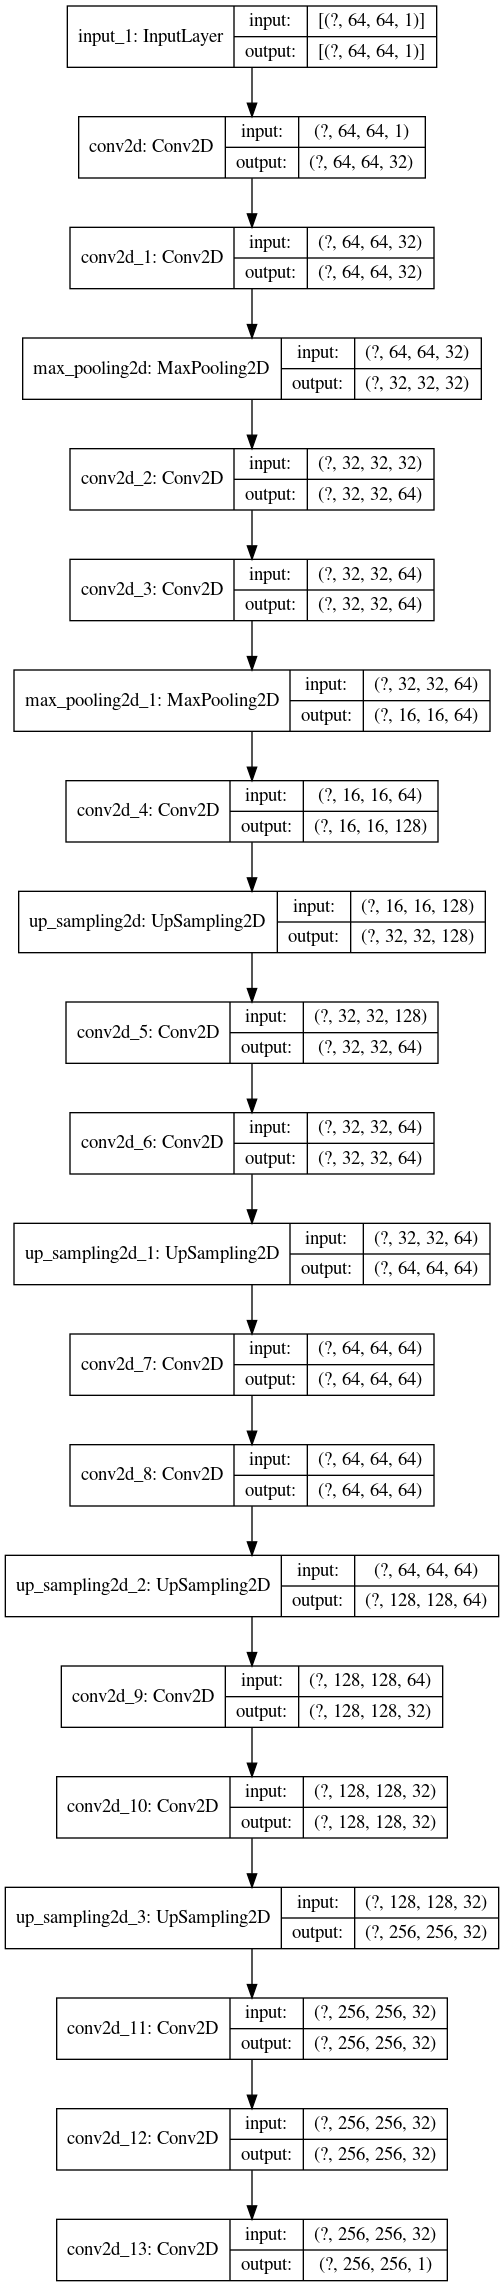

In [14]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, to_file='CNN.png')

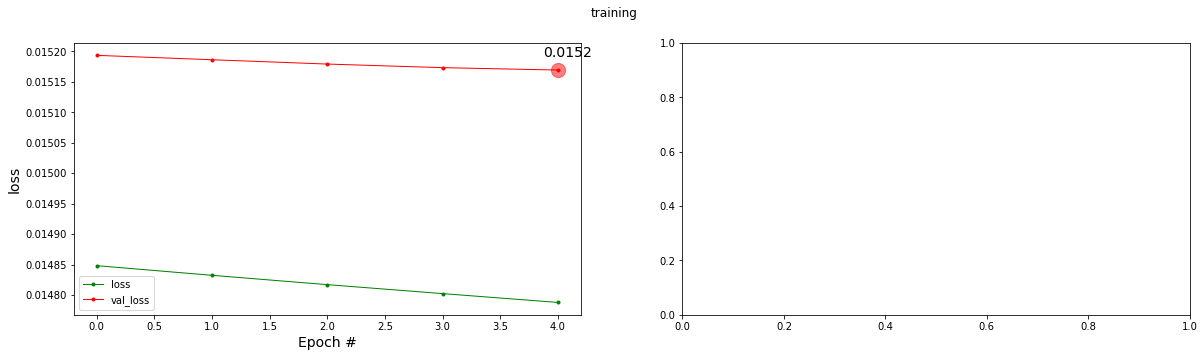

3840/3840 [==============================] - 2830s 737ms/step - loss: 0.0148 - val_loss: 0.0152


In [35]:
history = model.fit(train, verbose=1, validation_data=test, callbacks=[my_callbacks], epochs=5, validation_freq=1)

In [39]:
model.save('gs://era-ml-upressing/saved_models/autoencoder29') #was28

INFO:tensorflow:Assets written to: gs://era-ml-upressing/saved_models/autoencoder29/assets


In [16]:
model = tf.keras.models.load_model('gs://era-ml-upressing/saved_models/autoencoder29', compile=False)

In [18]:
x = train_low.take(18).batch(1)
prediction_test = model.predict(x)

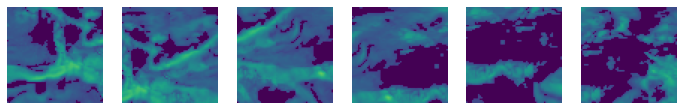

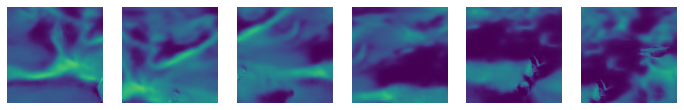

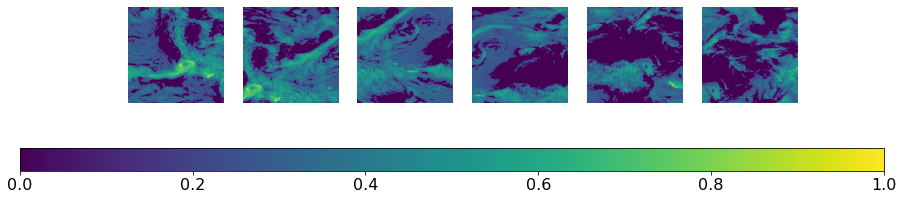

In [74]:
import matplotlib.pyplot as plt
import numpy 

fig, axes = plt.subplots(ncols=6, nrows=1, sharex=True, sharey=True, figsize=(12, 4))
for ax, example in zip(axes.flat, train_low.skip(1)):
    example=example.numpy()
    im = ax.imshow(example.reshape(64,64), vmin=0, vmax=1)  
#    fig.colorbar(im, ax=ax, orientation='vertical') 
    ax.axis('off')
fig, axes = plt.subplots(ncols=6, nrows=1, sharex=True, sharey=True, figsize=(12, 4))
for ax, example in zip(axes.flat, prediction_test[1:]):
    im = ax.imshow(example.reshape((256,256)), vmin=0, vmax=1)
#    fig.colorbar(im, ax=ax, orientation='vertical')
    ax.axis('off')
fig, axes = plt.subplots(ncols=6, nrows=1, sharex=True, sharey=True, figsize=(12, 4))
for ax, example in zip(axes.flat, train_high.skip(1)):
    example=example.numpy()
    im = ax.imshow(example.reshape(256,256), vmin=0, vmax=1)
#    fig.colorbar(im, ax=ax, orientation='vertical')
    ax.axis('off')
    
cbar_ax = fig.add_axes([0, 0.1, 1, 0.08])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal') 
cbar.ax.tick_params(labelsize=16)
